# Monte Carlo Simulations

This notebook is created to test strategies with Monte Carlo simulation by generating random stock price series.

The methodology is as follows:
- Use a statistical distribution based on historical SPY prices to generate series of daily close prices.
- Do Monte Carlo simulations to evaluate the returns of each strategy.

In [9]:
import numpy as np
import pandas as pd
from utils import misc
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
from scipy.stats import laplace, norm, gmean
# from tqdm.notebook import tqdm
from tqdm import tqdm
from bsm import bsm

pd.options.display.max_columns=300
pd.options.display.max_rows=100




### Dataset
Dataset is SPY (S&P 500 ETF). We take closing prices from yahoo finance.

In [10]:
# Get data from yahoo finance
misc.get_price_data('SPY')
df = pd.read_csv('datasets/stock_price_series/SPY.csv')
df = misc.clean_df(df)
# df = df.set_index('date')
df['close daily change'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
df = df.dropna()

df

,date,open,high,low,close,adjclose,volume,ticker,close daily change
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397572,480500,SPY,0.007112
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451397,201300,SPY,0.002119
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720430,529400,SPY,0.010571
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828049,531500,SPY,0.004184
5,1993-02-05,44.968750,45.062500,44.718750,44.968750,25.810114,492100,SPY,-0.000694
...,...,...,...,...,...,...,...,...,...
7581,2023-03-09,399.739990,401.480011,390.529999,391.559998,391.559998,111945300,SPY,-0.018450
7582,2023-03-10,390.989990,393.160004,384.320007,385.910004,385.910004,189105300,SPY,-0.014429
7583,2023-03-13,381.809998,390.390015,380.649994,385.359985,385.359985,157790000,SPY,-0.001425
7584,2023-03-14,390.500000,393.450012,387.049988,391.730011,391.730011,149752400,SPY,0.016530


### Statistics of SPY

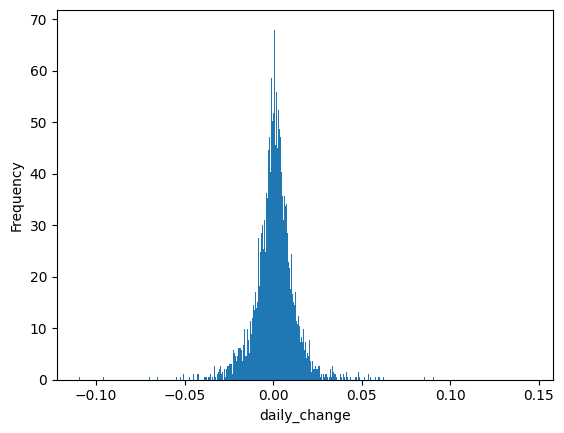

In [11]:
# Distribution of daily returns
count, bins, ignored = plt.hist(df['close daily change'], 1000, density=True)
plt.ylabel('Frequency')
plt.xlabel('daily_change')
plt.show()

Normal distribution:

(0.0003589810728432552, 0.01193788942245434)


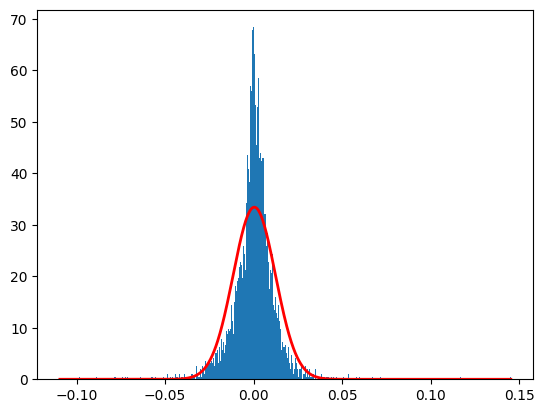

In [12]:
# Fit normal distribution parameters
norm_params = norm.fit(df['close daily change'])
print(norm_params)

# Plot daily return distribution
count, bins, ignored = plt.hist(df['close daily change'], 1000, density=True)

# Plot normal distribution with parameters
mu, sigma = norm_params
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

Laplace Distribution:

https://arxiv.org/ftp/arxiv/papers/1906/1906.10325.pdf

(0.0005961459399410431, 0.007941647501753628)


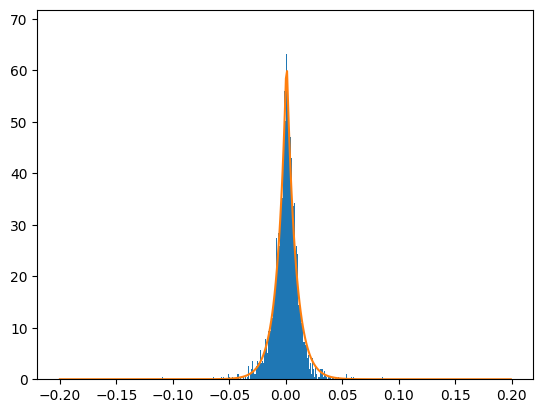

In [13]:
# Fit Laplace distribution parameters
laplace_params = laplace.fit(df['close daily change'])
print(laplace_params)

# Plot daily returns distribution
count, bins, ignored = plt.hist(df['close daily change'], 1000, density=True)

# Plot Laplace distribution with parameters
loc, scale = laplace_params
x = np.arange(-0.2, 0.2, .001)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)

The laplace distribution appears to be fit SPY daily returns distribution more closely.

We calculate the historical volatility of SPY for use in the BSM equation.

\begin{equation}
    \sigma_{annual} = \sigma_{daily} \times \sqrt{252}
\end{equation}

In [14]:
spy_hist_vol = np.std(df['close daily change']) * np.sqrt(252)
print("SPY Historical Volatility: " + "{:.2f}".format(spy_hist_vol * 100) + " %")

SPY Historical Volatility: 18.95 %


### Model Stock Replication

We create a model stock by:
- Generating a random series of daily returns distributed by the laplace distribution with previously fitted parameters.
- Specify an initial price.
- Calculate subsequent closing prices by multiplying by daily returns

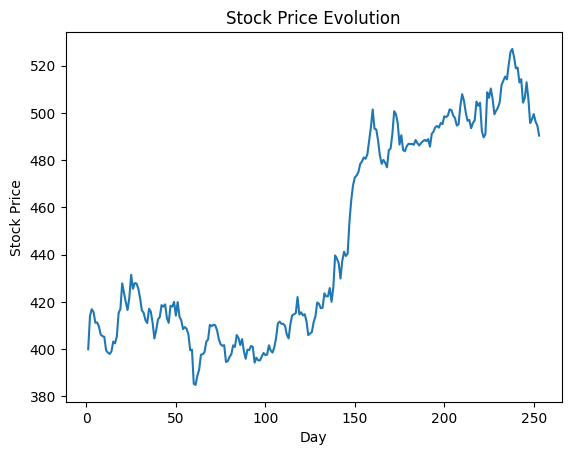

In [15]:
def generate_stock(laplace_params, num_days=252, initial_price=400):
    '''
    Generate array of stock prices according to laplace distribution
    '''
    # laplace parameters
    loc, scale = laplace_params
    
    # generate daily change from laplace distribution
    s = np.random.laplace(loc, scale, num_days)
    
    # generate stock price from daily change  
    stock_price = np.append(np.ones(1), np.cumprod(s + 1)) * initial_price
        
    return stock_price, s

# set 252 trading days in a year
num_days = 252
stock_price, daily_change = generate_stock(laplace_params, num_days, 400)
t = range(1, num_days + 2)
plt.plot(t, stock_price)

plt.title("Stock Price Evolution")
plt.ylabel('Stock Price')
plt.xlabel('Day')
plt.show()

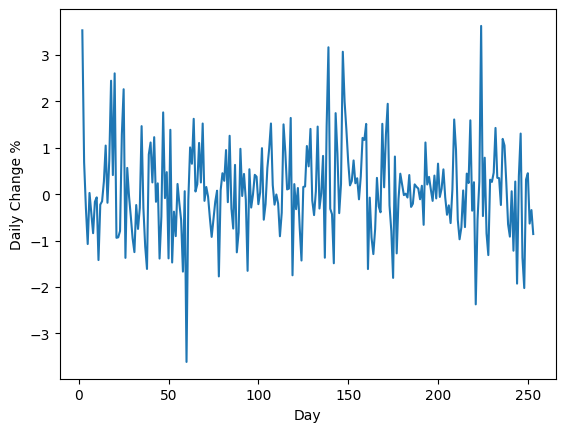

In [16]:
plt.plot(t[1:], daily_change * 100)
plt.ylabel('Daily Change %')
plt.xlabel('Day')
plt.show()

### Key Performance Indicators
These are variables that indicate the performance of the strategy.
1. Total Return
2. Compound Annualised Growth Rate
3. Volatility
4. Beta
5. Sharpe Ratio
6. Maximum Drawdown
7. Total Return / Maximum Drawdown

        


In [17]:
def get_kpi(rt, ch, stock_daily_change):
    '''
    Calculate key performance indicators from daily returns and daily changes of strategy.
    Input: daily returns, daily changes, daily changes
    '''
    kpi_dict = {
            'Total Return': rt[-1] - 1,
            'CAGR': gmean(ch) ** 252 - 1,
            'Volatility': np.std(ch - 1) * np.sqrt(252),
            'Beta': np.corrcoef(stock_daily_change, ch - 1)[0, 1] * np.std(stock_daily_change) * np.std(ch - 1) / np.var(stock_daily_change),
            'Sharpe Ratio': ((np.mean(ch) ** 252 - 1) - 0.03) / (np.std(ch - 1) * np.sqrt(252)),
        }
    
    # Find max return and max drawdown
    max_rt = 0
    max_dd = 0
    for i in range(len(rt)):
        if rt[i] > max_rt:
            max_rt = rt[i]
        else:
            if rt[i] - max_rt < max_dd:
                max_dd = rt[i] - max_rt
    
    kpi_dict['Max Drawdown'] = max_dd
    kpi_dict['RoMaxDD'] = kpi_dict['Total Return'] / (-kpi_dict['Max Drawdown'])
    kpi_dict['Daily Returns'] = rt
    kpi_dict['Daily Changes'] = ch
    
    return kpi_dict


class test:
    def __init__(self, strats_func):
        '''
        strats_func is a function to that runs several strategies at once
        strats_func input: stock price series
        strats_func output: dictionary with strategy names as keys and (daily returns, daily change) as value
        '''
        self.strats_func = strats_func
    
    def kpi_given_stock_price_series(self, stock_price_series, daily_change):
        '''
        Runs strats_func on the stock price series and returns kpi
        '''
        results = self.strats_func(stock_price_series)

        for strat in results:
            rt, ch = results[strat]
            kpi = get_kpi(rt, ch, daily_change)
            results[strat] = kpi

        return results
        
    def single_stock_price_series_expt(self, laplace_params, num_days=252, initial_price=400, display=False):
        '''
        Generates a single stock price series, runs strats_func, and returns kpi
        Statistics and graphs can be displayed
        '''
        # Generate stock price series
        stock_price_series, daily_change = generate_stock(laplace_params, num_days, initial_price)
        
        # Runs strategies and find kpi
        results = self.kpi_given_stock_price_series(stock_price_series, daily_change)

        # Display statistics and graphs
        if display:
            for strat in results:
                kpi = results[strat]

                
                print(strat)
                print('Total Return:          {:.2f} %'.format(kpi['Total Return'] * 100))
                print('CAGR:                  {:.2f} %'.format(kpi['CAGR'] * 100))
                print('Volatility:            {:.2f} %'.format(kpi['Volatility'] * 100))
                print('Beta:                  {:.2f}'.format(kpi['Beta']))
                print('Sharpe Ratio:          {:.2f}'.format(kpi['Sharpe Ratio']))
                print('Max Drawdown:          {:.2f} %'.format(kpi['Max Drawdown'] * 100))
                print('Return over Max DD:    {:.2f}'.format(kpi['RoMaxDD']))
                print('-------------------------------------')

                plt.plot(range(num_days + 1), kpi['Daily Returns'], label=strat)

            plt.xlabel('Time in Days')
            plt.ylabel('Strategy Returns')    
            plt.legend()
            plt.show()
            
        return results

    def multiple_stock_price_series_expt(self, runs, laplace_params, num_days=252, initial_price=400, display=False):
        '''
        Generates multiple stock price series, runs strats_func, and returns average kpi across all runs
        Statistics and graphs can be displayed
        '''
        # Initiate raw results to collect all data
        raw_results = {}


        rng = tqdm(range(runs))

        # Run expt for n times with generated stock price series
        for i in rng:

            # Generate stock price series
            stock_price_series, daily_change = generate_stock(laplace_params, num_days, initial_price)

            # Run strategies and find kpi
            results = self.kpi_given_stock_price_series(stock_price_series, daily_change)

            # Save results
            for strat in results:
                kpi = results[strat]

                # Initialise dict on the 1st run
                if i == 0:
                    raw_results[strat] = []
            
                raw_results[strat].append(kpi)

        # Find average results
        avg_results = {}

        for strat in raw_results:
            avg_results[strat] = {}

            # Average kpi values for all runs
            for key in kpi:
                avg_results[strat][key] = np.mean([f[key] for f in raw_results[strat]])

            # Find winrate of strategy => win = total return at the end of run > 0
            avg_results[strat]['Win-rate'] = np.sum([1 for f in raw_results[strat] if f['Total Return'] > 0]) \
                / runs
            
        
        # display average results
        if display:
            for strat in avg_results:
                print(strat)
                
                print('Total Return:            {:.2f} %'.format(avg_results[strat]['Total Return'] * 100))
                print('CAGR:                    {:.2f} %'.format(avg_results[strat]['CAGR'] * 100))
                print('Volatility:              {:.2f} %'.format(avg_results[strat]['Volatility'] * 100))
                print('Beta:                    {:.2f}'.format(avg_results[strat]['Beta']))
                print('Sharpe Ratio:            {:.2f}'.format(avg_results[strat]['Sharpe Ratio']))
                print('Win-rate:                {:.2f} %'.format(avg_results[strat]['Win-rate'] * 100))
                print('Max Drawdown:            {:.2f} %'.format(avg_results[strat]['Max Drawdown'] * 100))
                print('Return over Max DD:      {:.2f}'.format(avg_results[strat]['RoMaxDD']))
                
                
                print('-------------------------------------')
        
        return avg_results
            




Strategy should return:
1. Daily returns (1.xx)
2. Daily changes in portfolio value (1.xx)

### Buy-Hold Strategy
Buy assets at the start and hold until the end

In [18]:
def buy_hold_strategy(stock_price):
    arr = stock_price/stock_price[0]
    return arr, arr[1:] / arr[:-1]

Single run results:

Single Run Results:
buy_hold
Total Return:          26.73 %
CAGR:                  26.73 %
Volatility:            17.43 %
Beta:                  1.00
Sharpe Ratio:          1.47
Max Drawdown:          -20.50 %
Return over Max DD:    1.30
-------------------------------------


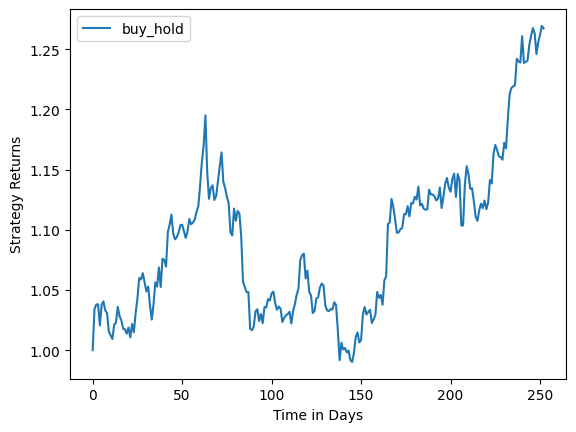

Multiple Run Results:


100%|██████████| 1000/1000 [00:00<00:00, 2002.19it/s]

buy_hold
Total Return:            16.74 %
CAGR:                    16.74 %
Volatility:              17.70 %
Beta:                    1.00
Sharpe Ratio:            0.88
Win-rate:                77.40 %
Max Drawdown:            -16.88 %
Return over Max DD:      1.42
-------------------------------------


In [19]:
def buy_hold_strat_func(stock_price):
    return {'buy_hold': buy_hold_strategy(stock_price)}

buy_hold_test = test(buy_hold_strat_func)

print('Single Run Results:')
_ = buy_hold_test.single_stock_price_series_expt(laplace_params=laplace_params, display=True)
print('Multiple Run Results:')
_ = buy_hold_test.multiple_stock_price_series_expt(1000, laplace_params, display=True)


  0%|          | 0/40 [00:00<?, ?it/s]C:\Users\alexr\AppData\Local\Temp\ipykernel_3208\1739053095.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  kpi_dict['RoMaxDD'] = kpi_dict['Total Return'] / (-kpi_dict['Max Drawdown'])
100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


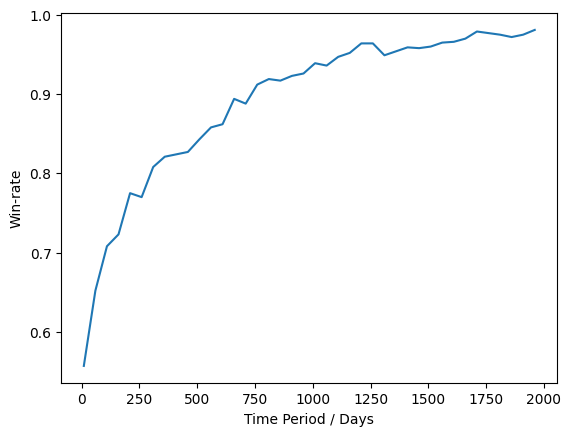

In [20]:
y_tr = []
y_vol = []
rng = range(10, 2000, 50)
for i in tqdm(rng):
    res = buy_hold_test.multiple_stock_price_series_expt(1000, laplace_params, num_days=i)
    y_tr.append(res['buy_hold']['Win-rate'])
    y_vol.append(res['buy_hold']['Volatility'])

plt.plot(rng, y_tr)
plt.xlabel('Time Period / Days')
plt.ylabel('Win-rate')
plt.show()

Win-rate increases with investment time-horizon.

### Buy-write strategy

This strategy replicates the CBOE SP500 buy-write index. We hold assets in the underlying index and sell ATM covered calls every month to generate income with the option premium. This strategy is supposed to generate consistent returns with low volatility, at the expense of capping the upside.

This strategy is used by the funds QYLD, XYLD.

In [21]:

def buy_write_strategy(stock_price, dte=22, initial_capital=1E6, volatility=spy_hist_vol, rf_rate=0.03):
    num_days = len(stock_price) - 1

    cash = initial_capital
    call_dte = 0
    day = 0
    call_value = 0
    stock_value = 0
    call_pos = 0
    stock_pos = 0
    port_value = np.array([0])
    call_strike = 0

    while day <= num_days:
        # print(f'- day: {day}, stock price: {stock_price[day]}')
        if day % dte == 0:

            if call_pos != 0:
                # close the calls
                if stock_price[day] < call_strike:
                    pass
                    # print(f'--- {call_pos} calls expire OTM')
                else:
                    stock_pos += call_pos
                    cash += -call_pos * call_strike
                    # print(f'--- {call_pos} calls called away @ {call_strike} for {-call_pos * call_strike}')
                call_pos = 0

            # buy stock
            # print(f'--- buy {cash // stock_price[day]} stock @ {stock_price[day]}')
            new_pos = cash // stock_price[day]
            stock_pos += new_pos
            cash -= new_pos * stock_price[day]
            # sell calls
            call_strike = int(stock_price[day])
            _, call_price, _, _ = bsm(stock_price=stock_price[day], strike_price=call_strike, dte=dte, volatility=volatility, rf_rate=rf_rate)
            call_pos = -stock_pos
            # print(f'--- sell {-stock_pos} strike {call_strike} calls @ {call_price}')
            cash += -call_pos * call_price

        stock_value = stock_pos * stock_price[day]
        # print(f'-- stock value: {stock_value}')
        _, call_price, _, _ = bsm(stock_price=stock_price[day], strike_price=call_strike, dte=(dte - day % dte), volatility=volatility)
        call_value = call_pos * call_price
        # print(f'-- call value: {call_value}')
        # print(f'-- cash: {cash}')
        port_value = np.append(port_value, stock_value + call_value + cash)
        # print(f'-- portfolio value: {port_value[-1]}')

        day += 1

    port_returns = port_value[1:] / initial_capital
    return port_returns, port_returns[1:] / port_returns[:-1]



Single Run Results:
buy_write
Total Return:          14.40 %
CAGR:                  14.40 %
Volatility:            7.99 %
Beta:                  0.39
Sharpe Ratio:          1.47
Max Drawdown:          -4.97 %
Return over Max DD:    2.90
-------------------------------------
buy_hold
Total Return:          7.37 %
CAGR:                  7.37 %
Volatility:            16.93 %
Beta:                  1.00
Sharpe Ratio:          0.35
Max Drawdown:          -12.75 %
Return over Max DD:    0.58
-------------------------------------


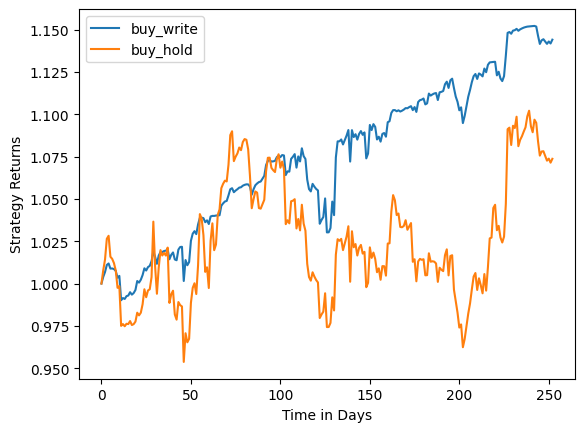

Multiple Run Results:


100%|██████████| 1000/1000 [01:15<00:00, 13.25it/s]

buy_write
Total Return:            5.28 %
CAGR:                    5.28 %
Volatility:              9.15 %
Beta:                    0.43
Sharpe Ratio:            0.42
Win-rate:                74.30 %
Max Drawdown:            -9.37 %
Return over Max DD:      1.11
-------------------------------------
buy_hold
Total Return:            15.69 %
CAGR:                    15.69 %
Volatility:              17.67 %
Beta:                    1.00
Sharpe Ratio:            0.82
Win-rate:                76.80 %
Max Drawdown:            -16.98 %
Return over Max DD:      1.30
-------------------------------------


In [22]:
def buy_write_strat_func(stock_price):
    return {
        'buy_write': buy_write_strategy(stock_price),
        'buy_hold': buy_hold_strategy(stock_price)
        }

buy_write_test = test(buy_write_strat_func)

print('Single Run Results:')
_ = buy_write_test.single_stock_price_series_expt(laplace_params=laplace_params, display=True)
print('Multiple Run Results:')
_ = buy_write_test.multiple_stock_price_series_expt(1000, laplace_params, display=True)

### Dollar Cost Average Strategy
Divide initial capital into equal amounts to be invested into assets at regular frequency.

In [23]:
def dca_strategy(stock_price, dca_period=22, initial_capital=1E6):
    num_days = len(stock_price)
    dca_num = np.ceil(num_days / dca_period)
    dca_amount = initial_capital // dca_num
    cash = initial_capital
    stock_pos = np.array([0])
    cash_pos = np.array([0])
    

    for day in range(num_days):
        stock_pos = np.append(stock_pos, stock_pos[-1])
        if day % dca_period == 0:
            dca_stock_pos = dca_amount // stock_price[day]
            stock_pos[-1] += dca_stock_pos
            cash -= dca_stock_pos * stock_price[day]
            
        cash_pos = np.append(cash_pos, cash)
    
    stock_pos = stock_pos[1:]
    cash_pos = cash_pos[1:]

    port_value = stock_price * stock_pos + cash_pos
    arr = (port_value / initial_capital)  
    
    return arr, arr[1:] / arr[:-1]


Single Run Results:
dca
Total Return:          20.91 %
CAGR:                  20.91 %
Volatility:            11.56 %
Beta:                  0.58
Sharpe Ratio:          1.62
Max Drawdown:          -5.45 %
Return over Max DD:    3.84
-------------------------------------
buy_hold
Total Return:          30.38 %
CAGR:                  30.38 %
Volatility:            17.63 %
Beta:                  1.00
Sharpe Ratio:          1.67
Max Drawdown:          -13.32 %
Return over Max DD:    2.28
-------------------------------------


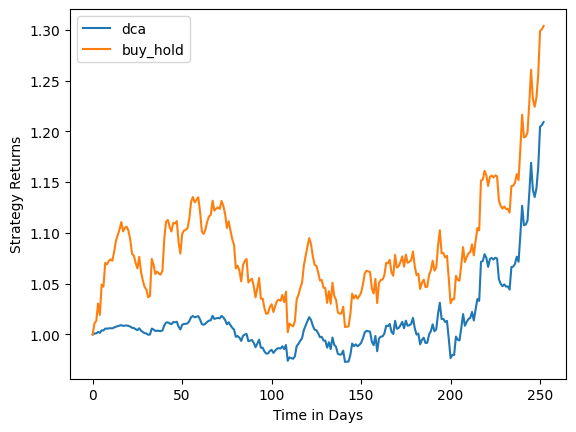

Multiple Run Results:


100%|██████████| 1000/1000 [00:03<00:00, 306.23it/s]

dca
Total Return:            8.64 %
CAGR:                    8.64 %
Volatility:              10.57 %
Beta:                    0.53
Sharpe Ratio:            0.58
Win-rate:                74.20 %
Max Drawdown:            -10.03 %
Return over Max DD:      1.37
-------------------------------------
buy_hold
Total Return:            16.74 %
CAGR:                    16.74 %
Volatility:              17.81 %
Beta:                    1.00
Sharpe Ratio:            0.88
Win-rate:                77.50 %
Max Drawdown:            -17.00 %
Return over Max DD:      1.41
-------------------------------------


In [24]:
def dca_strat_func(stock_price):
    return {
        'dca': dca_strategy(stock_price),
        'buy_hold': buy_hold_strategy(stock_price)
        }

dca_test = test(dca_strat_func)

print('Single Run Results:')
_ = dca_test.single_stock_price_series_expt(laplace_params=laplace_params, display=True)
print('Multiple Run Results:')
_ = dca_test.multiple_stock_price_series_expt(1000, laplace_params, display=True)

### Leveraged Daily Returns Strategy
Strategy for leveraged funds such as UPRO and TQQQ. The daily changes of the underlying index is replicated with leverage.

In [25]:
def leveraged_strategy(stock_price, leverage=3):

    arr = stock_price / stock_price[0]
    
    daily_changes = leverage * ((stock_price[1:] / stock_price[:-1]) - 1)

    daily_returns = np.insert(np.cumprod(daily_changes + 1), 0, 1)
    
    return daily_returns, daily_changes + 1

Single Run Results:
3x leverage
Total Return:          36.98 %
CAGR:                  36.98 %
Volatility:            55.60 %
Beta:                  3.00
Sharpe Ratio:          1.03
Max Drawdown:          -78.10 %
Return over Max DD:    0.47
-------------------------------------
buy_hold
Total Return:          14.98 %
CAGR:                  14.98 %
Volatility:            18.53 %
Beta:                  1.00
Sharpe Ratio:          0.75
Max Drawdown:          -20.77 %
Return over Max DD:    0.72
-------------------------------------


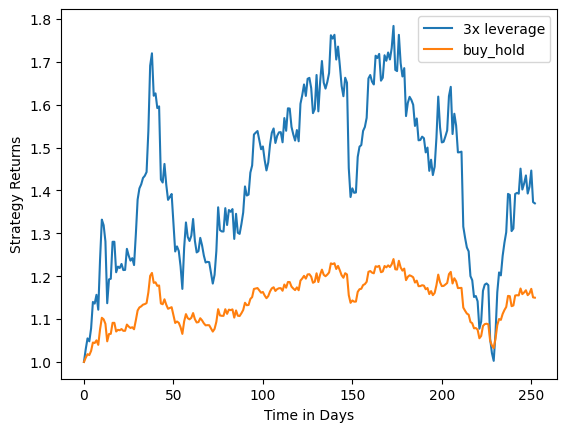

Multiple Run Results:


100%|██████████| 1000/1000 [00:00<00:00, 1013.28it/s]


3x leverage
Total Return:            58.90 %
CAGR:                    58.90 %
Volatility:              53.22 %
Beta:                    3.00
Sharpe Ratio:            1.51
Win-rate:                72.70 %
Max Drawdown:            -61.38 %
Return over Max DD:      1.10
-------------------------------------
buy_hold
Total Return:            16.79 %
CAGR:                    16.79 %
Volatility:              17.74 %
Beta:                    1.00
Sharpe Ratio:            0.88
Win-rate:                78.60 %
Max Drawdown:            -16.90 %
Return over Max DD:      1.41
-------------------------------------


In [26]:
def leverage_strat_func(stock_price):
    return {
        '3x leverage': leveraged_strategy(stock_price),
        'buy_hold': buy_hold_strategy(stock_price)
        }

leverage_test = test(leverage_strat_func)

print('Single Run Results:')
_ = leverage_test.single_stock_price_series_expt(laplace_params=laplace_params, display=True)
print('Multiple Run Results:')
_ = leverage_test.multiple_stock_price_series_expt(1000, laplace_params, display=True)

In [27]:
def lev_range_strats_func(stock_price):
    results = {}
    for i in range(1, 5):
        results[i] = leveraged_strategy(stock_price, leverage=i)
    
    return results


lev_range_test = test(lev_range_strats_func)

print('Multiple Run Results:')
res = lev_range_test.multiple_stock_price_series_expt(1000, laplace_params, display=True)


Multiple Run Results:


100%|██████████| 1000/1000 [00:01<00:00, 503.07it/s]

1
Total Return:            17.64 %
CAGR:                    17.64 %
Volatility:              17.77 %
Beta:                    1.00
Sharpe Ratio:            0.93
Win-rate:                78.70 %
Max Drawdown:            -16.74 %
Return over Max DD:      1.49
-------------------------------------
2
Total Return:            38.46 %
CAGR:                    38.46 %
Volatility:              35.53 %
Beta:                    2.00
Sharpe Ratio:            1.26
Win-rate:                75.90 %
Max Drawdown:            -36.82 %
Return over Max DD:      1.34
-------------------------------------
3
Total Return:            63.05 %
CAGR:                    63.05 %
Volatility:              53.30 %
Beta:                    3.00
Sharpe Ratio:            1.60
Win-rate:                72.60 %
Max Drawdown:            -61.38 %
Return over Max DD:      1.18
-------------------------------------
4
Total Return:            92.06 %
CAGR:                    92.06 %
Volatility:              71.07 %
Beta:      

### Comparison between strategies

Single Run Results:
buy_write
Total Return:          9.82 %
CAGR:                  9.82 %
Volatility:            9.11 %
Beta:                  0.39
Sharpe Ratio:          0.80
Max Drawdown:          -6.34 %
Return over Max DD:    1.55
-------------------------------------
dca
Total Return:          22.53 %
CAGR:                  22.53 %
Volatility:            10.23 %
Beta:                  0.52
Sharpe Ratio:          1.97
Max Drawdown:          -5.72 %
Return over Max DD:    3.94
-------------------------------------
3x leverage
Total Return:          142.17 %
CAGR:                  142.17 %
Volatility:            52.22 %
Beta:                  3.00
Sharpe Ratio:          3.34
Max Drawdown:          -43.99 %
Return over Max DD:    3.23
-------------------------------------
buy_hold
Total Return:          38.47 %
CAGR:                  38.47 %
Volatility:            17.41 %
Beta:                  1.00
Sharpe Ratio:          2.16
Max Drawdown:          -10.86 %
Return over Max DD:    3.5

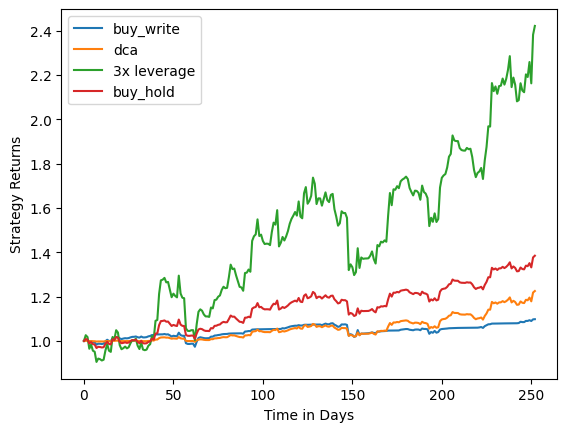

Multiple Run Results:


100%|██████████| 1000/1000 [01:18<00:00, 12.68it/s]

buy_write
Total Return:            5.31 %
CAGR:                    5.31 %
Volatility:              9.17 %
Beta:                    0.43
Sharpe Ratio:            0.43
Win-rate:                72.80 %
Max Drawdown:            -9.53 %
Return over Max DD:      1.20
-------------------------------------
dca
Total Return:            8.86 %
CAGR:                    8.86 %
Volatility:              10.51 %
Beta:                    0.53
Sharpe Ratio:            0.60
Win-rate:                75.70 %
Max Drawdown:            -10.05 %
Return over Max DD:      1.38
-------------------------------------
3x leverage
Total Return:            61.68 %
CAGR:                    61.68 %
Volatility:              53.11 %
Beta:                    3.00
Sharpe Ratio:            1.57
Win-rate:                73.10 %
Max Drawdown:            -62.76 %
Return over Max DD:      1.10
-------------------------------------
buy_hold
Total Return:            17.18 %
CAGR:                    17.18 %
Volatility:            

In [28]:
def comparison_strat_func(stock_price):
    return {
        'buy_write': buy_write_strategy(stock_price),
        'dca': dca_strategy(stock_price),
        '3x leverage': leveraged_strategy(stock_price),
        'buy_hold': buy_hold_strategy(stock_price)
        }
     
comparison_test = test(comparison_strat_func)

print('Single Run Results:')
_ = comparison_test.single_stock_price_series_expt(laplace_params=laplace_params, display=True)
print('Multiple Run Results:')
_ = comparison_test.multiple_stock_price_series_expt(1000, laplace_params, display=True)

### Range of Leverage

In [29]:

leverage_arr = np.arange(-5, 5.5, 0.1)

leverage_arr = [f for f in leverage_arr if f < -0.3 or f > 0.3]

def lev_test_strat_func(stock_price):
    dict1 = {f: leveraged_strategy(stock_price, leverage=f) for f in leverage_arr}
    return dict1
     
lev_test = test(lev_test_strat_func)


lev_test_avg_res = lev_test.multiple_stock_price_series_expt(1000, laplace_params)


    

100%|██████████| 1000/1000 [00:47<00:00, 21.01it/s]


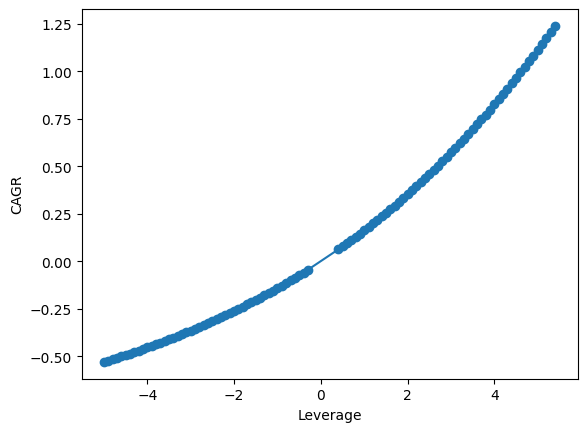

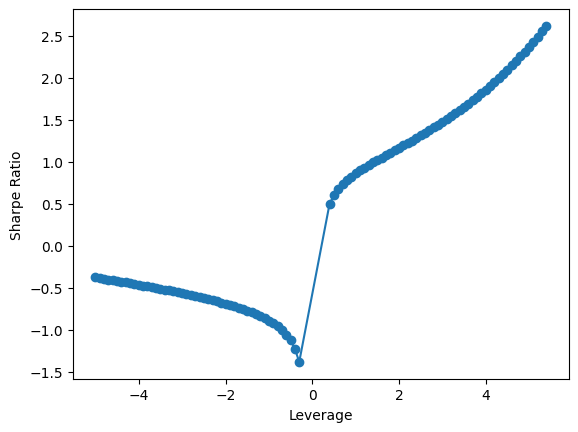

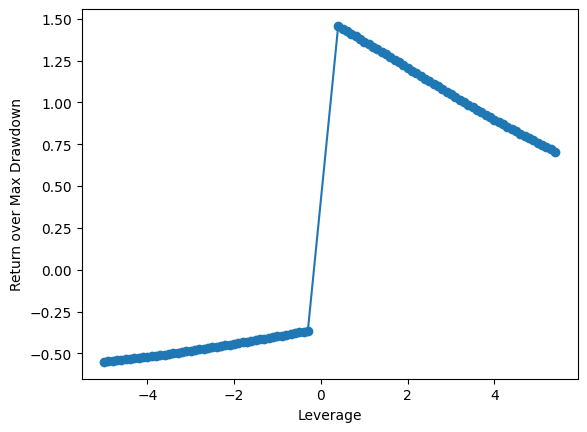

In [30]:
x = []
y_cagr = []
y_mar = []
y_sr = []
for i in lev_test_avg_res:
    x.append(i)
    # print(lev_test_avg_res[i])
    y_cagr.append(lev_test_avg_res[i]['CAGR'])
    y_mar.append(lev_test_avg_res[i]['RoMaxDD'])
    y_sr.append(lev_test_avg_res[i]['Sharpe Ratio'])

plt.plot(x, y_cagr, marker='o')
plt.xlabel('Leverage')
plt.ylabel('CAGR')
plt.show()

plt.plot(x, y_sr, marker='o')
plt.xlabel('Leverage')
plt.ylabel('Sharpe Ratio')
plt.show()

plt.plot(x, y_mar, marker='o')
plt.xlabel('Leverage')
plt.ylabel('Return over Max Drawdown')
plt.show()

Find strike price given current price of underlying and delta

In [31]:
def option_price_given_delta(stock_price, delta, dte, volatility, rf_rate=0.03):
    '''
    Find option strike price and option price given delta and underlying stock price.
    Type of option determined by delta:
    delta > 0 -> call option
    delta < 0 -> put option

    Input:
    1. current price of underying
    2. delta
    3. dte
    4. volatility
    5. risk-free rate

    Output
    1. strike price
    2. option price
    '''
    strike_price = stock_price
    # delta > 0 -> call option
    if delta > 0:
        opt_delta = 0.5
        # OTM call
        if delta <= opt_delta:
            while delta <= opt_delta:
                strike_price += 1
                opt_delta, opt_price, _, _ = bsm(stock_price, strike_price, dte, volatility=volatility, rf_rate=rf_rate)
        # ITM call
        else:
            while delta > opt_delta:
                strike_price -= 1
                opt_delta, opt_price, _, _ = bsm(stock_price, strike_price, dte, volatility=volatility, rf_rate=rf_rate)
    # delta < 0 -> put option
    else:
        opt_delta = -0.5
        # OTM put
        if delta >= opt_delta:
            while delta >= opt_delta:
                strike_price -= 1
                _, _, opt_delta, opt_price = bsm(stock_price, strike_price, dte, volatility=volatility, rf_rate=rf_rate)
        # ITM put
        else:
            while delta < opt_delta:
                strike_price += 1
                _, _, opt_delta, opt_price = bsm(stock_price, strike_price, dte, volatility=volatility, rf_rate=rf_rate)

    
    return strike_price, opt_price

print(option_price_given_delta(400, -0.6, 22, volatility=spy_hist_vol))

(406, 10.397078696116438)


Modified buy-write with varying delta

In [34]:
def variable_delta_buy_write_strategy(stock_price, dte=22, delta=0.5, initial_capital=1E6, volatility=spy_hist_vol, rf_rate=0.03):
    num_days = len(stock_price) - 1

    cash = initial_capital
    day = 0
    call_value = 0
    stock_value = 0
    call_pos = 0
    stock_pos = 0
    port_value = np.array([0])
    call_strike = 0

    while day <= num_days:
        # print(f'- day: {day}, stock price: {stock_price[day]}')
        if day % dte == 0:

            if call_pos != 0:
                # close the calls
                if stock_price[day] < call_strike:
                    pass
                    # print(f'--- {call_pos} calls expire OTM')
                else:
                    stock_pos += call_pos
                    cash += -call_pos * call_strike
                    # print(f'--- {call_pos} calls called away @ {call_strike} for {-call_pos * call_strike}')
                call_pos = 0

            # buy stock
            # print(f'--- buy {cash // stock_price[day]} stock @ {stock_price[day]}')
            new_pos = cash // stock_price[day]
            stock_pos += new_pos
            cash -= new_pos * stock_price[day]
            # sell calls at specified delta
            call_strike, call_price = option_price_given_delta(stock_price=stock_price[day], delta=delta, dte=dte, volatility=volatility, rf_rate=rf_rate)
            call_pos = -stock_pos
            # print(f'--- sell {-stock_pos} strike {call_strike} calls @ {call_price}')
            cash += -call_pos * call_price

        stock_value = stock_pos * stock_price[day]
        # print(f'-- stock value: {stock_value}')
        _, call_price, _, _ = bsm(stock_price=stock_price[day], strike_price=call_strike, dte=(dte - day % dte), volatility=volatility)
        call_value = call_pos * call_price
        # print(f'-- call value: {call_value}')
        # print(f'-- cash: {cash}')
        port_value = np.append(port_value, stock_value + call_value + cash)
        # print(f'-- portfolio value: {port_value[-1]}')

        day += 1

    port_returns = port_value[1:] / initial_capital
    return port_returns, port_returns[1:] / port_returns[:-1]

### Range of Delta for buy-write strategy
We vary the delta of the calls sold.

In [35]:
delta_range = np.arange(0.2, 0.8, 0.05)
print(delta_range)
def delta_range_strat_func(stock_price):
    dict1 = {f: variable_delta_buy_write_strategy(stock_price, delta=f) for f in delta_range}
    return dict1
     
delta_range_test = test(delta_range_strat_func)


delta_range_avg_res = delta_range_test.multiple_stock_price_series_expt(500, laplace_params)

[0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8 ]


100%|██████████| 500/500 [10:48<00:00,  1.30s/it]


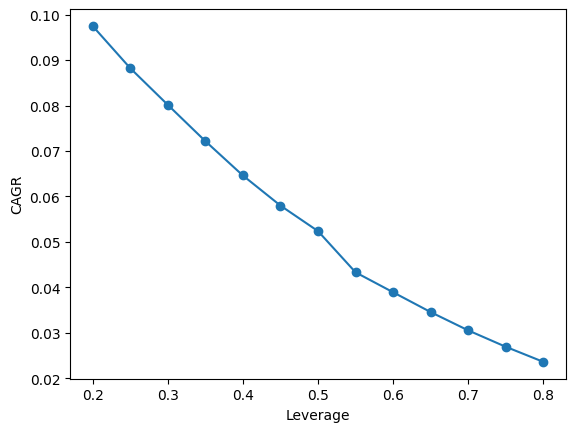

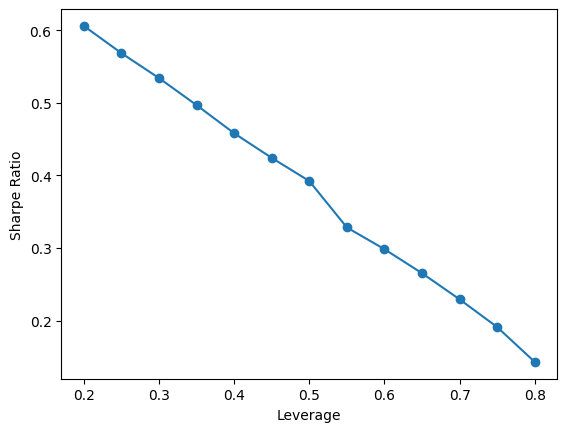

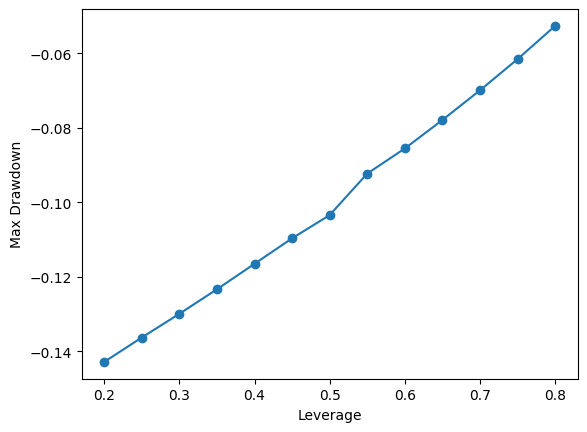

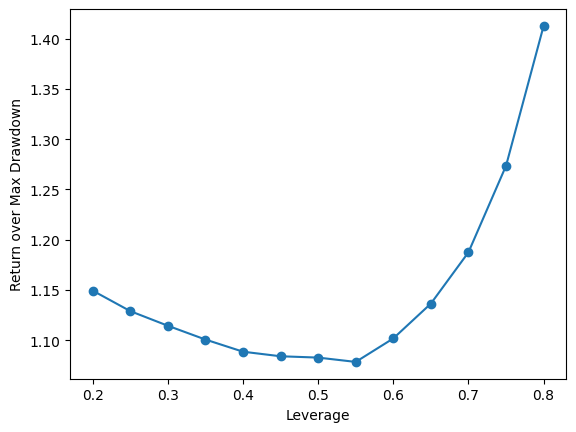

In [36]:
x = []
y_cagr = []
y_mar = []
y_sr = []
y_dd = []
for i in delta_range_avg_res:
    x.append(i)
    # print(lev_test_avg_res[i])
    y_cagr.append(delta_range_avg_res[i]['CAGR'])
    y_mar.append(delta_range_avg_res[i]['RoMaxDD'])
    y_sr.append(delta_range_avg_res[i]['Sharpe Ratio'])
    y_dd.append(delta_range_avg_res[i]['Max Drawdown'])

plt.plot(x, y_cagr, marker='o')
plt.xlabel('Leverage')
plt.ylabel('CAGR')
plt.show()

plt.plot(x, y_sr, marker='o')
plt.xlabel('Leverage')
plt.ylabel('Sharpe Ratio')
plt.show()

plt.plot(x, y_dd, marker='o')
plt.xlabel('Leverage')
plt.ylabel('Max Drawdown')
plt.show()

plt.plot(x, y_mar, marker='o')
plt.xlabel('Leverage')
plt.ylabel('Return over Max Drawdown')
plt.show()

### Range of DTE
We vary the days to expiry of the calls sold.

In [37]:
dte_range = np.arange(2, 44, 2)
print(dte_range)
def dte_range_strat_func(stock_price):
    dict1 = {f: variable_delta_buy_write_strategy(stock_price, dte=f, delta=0.5) for f in dte_range}
    return dict1
     
dte_range_test = test(dte_range_strat_func)


dte_range_avg_res = dte_range_test.multiple_stock_price_series_expt(500, laplace_params)

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42]


100%|██████████| 500/500 [13:46<00:00,  1.65s/it]


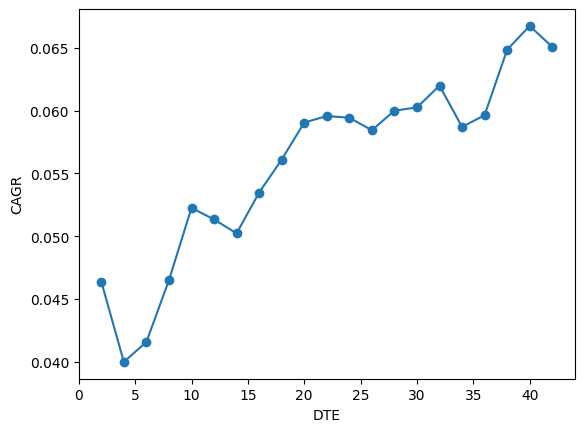

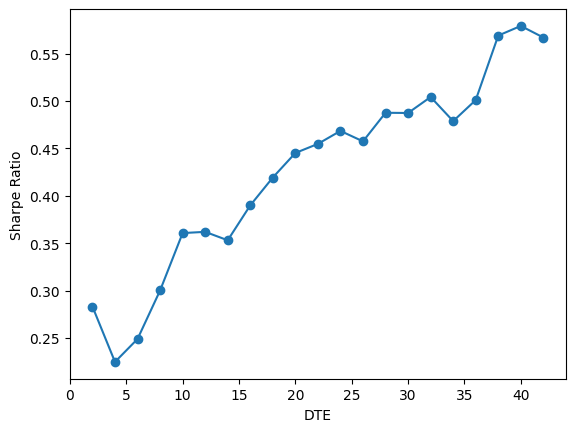

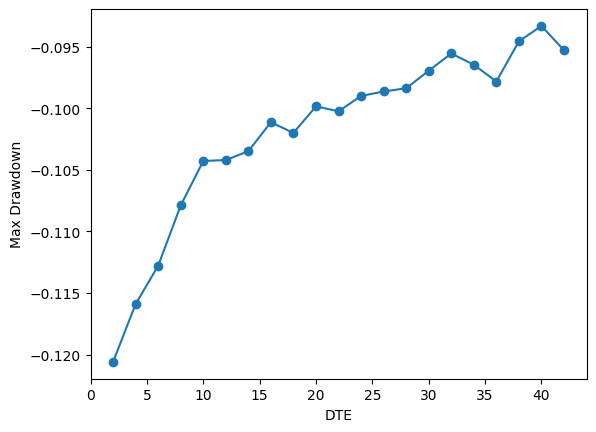

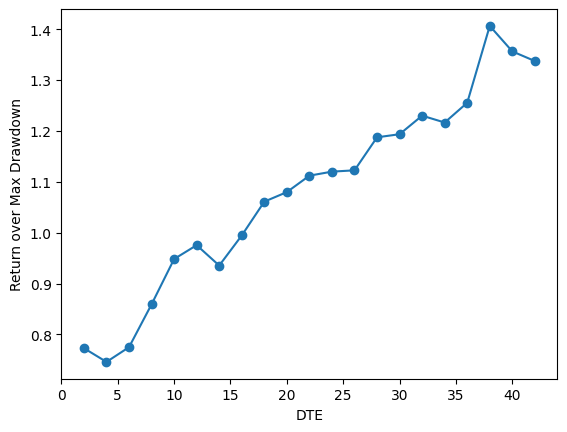

In [38]:
x = []
y_cagr = []
y_mar = []
y_sr = []
y_dd = []
for i in dte_range_avg_res:
    x.append(i)
    # print(lev_test_avg_res[i])
    y_cagr.append(dte_range_avg_res[i]['CAGR'])
    y_mar.append(dte_range_avg_res[i]['RoMaxDD'])
    y_sr.append(dte_range_avg_res[i]['Sharpe Ratio'])
    y_dd.append(dte_range_avg_res[i]['Max Drawdown'])

plt.plot(x, y_cagr, marker='o')
plt.xlabel('DTE')
plt.ylabel('CAGR')
plt.show()

plt.plot(x, y_sr, marker='o')
plt.xlabel('DTE')
plt.ylabel('Sharpe Ratio')
plt.show()

plt.plot(x, y_dd, marker='o')
plt.xlabel('DTE')
plt.ylabel('Max Drawdown')
plt.show()

plt.plot(x, y_mar, marker='o')
plt.xlabel('DTE')
plt.ylabel('Return over Max Drawdown')
plt.show()

Longer dated options seem to be associated with better results including sharpe ratio and calmar ratio. There seems to be some anomalies with regards to short DTE options (2 DTE).

We also note that longer dated option implies lesser trades within the time period. Thus, results are likely to be more volatile.